# ディープラーニングフレームワーク PyTorch を利用した実装

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
# 訓練データをdatasetsからダウンロード
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# テストデータをdatasetsからダウンロード
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
epoch_num = 20  # エポック数を設定する
batch_size = 100  # バッチの数
learning_rate = 0.1  # 学習係数

In [4]:
# データローダーの作成
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([100, 1, 28, 28])
Shape of y:  torch.Size([100]) torch.int64


In [5]:
# 訓練に際して、可能であればGPU（cuda）を設定します。GPUが搭載されていない場合はCPUを使用します
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# modelを定義します
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_sigmoid_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Sigmoid(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_sigmoid_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_sigmoid_stack): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)


In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()  # 訓練モード
    loss_list = []
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y = torch.eye(10)[y]  # one-hot形式に変換
        
        # 損失誤差を計算
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # バックプロパゲーション
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
    
    return loss_list

In [8]:
def test(dataloader, model):
    model.eval()  # 評価モード
    correct = 0
    size = len(dataloader.dataset)
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y = torch.eye(10)[y]  # one-hot形式に変換
            pred = model(X)
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    correct /= size
    
    return correct

In [9]:
train_loss_list = []
train_acc_list = [0.0]
test_acc_list = [0.0]

for t in range(epoch_num):
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_loss_list += train_loss
    print(f'epoch({t + 1}) loss = {train_loss_list[-1]}')
    train_acc = test(train_dataloader, model)
    train_acc_list.append(train_acc)
    test_acc = test(test_dataloader, model)
    test_acc_list.append(test_acc)
    print(f'epoch({t + 1}) accuracy(train, test) = ({train_acc}, {test_acc})')

print("Done!")

epoch(1) loss = 0.6521042585372925
epoch(1) accuracy(train, test) = (0.8491166666666666, 0.8558)
epoch(2) loss = 0.43093636631965637
epoch(2) accuracy(train, test) = (0.88985, 0.8974)
epoch(3) loss = 0.3647152781486511
epoch(3) accuracy(train, test) = (0.9033333333333333, 0.9083)
epoch(4) loss = 0.3313988447189331
epoch(4) accuracy(train, test) = (0.9117166666666666, 0.9153)
epoch(5) loss = 0.3100023567676544
epoch(5) accuracy(train, test) = (0.9171, 0.9208)
epoch(6) loss = 0.2945067882537842
epoch(6) accuracy(train, test) = (0.9217333333333333, 0.9242)
epoch(7) loss = 0.28258830308914185
epoch(7) accuracy(train, test) = (0.9257166666666666, 0.9272)
epoch(8) loss = 0.27304190397262573
epoch(8) accuracy(train, test) = (0.929, 0.9295)
epoch(9) loss = 0.2650938928127289
epoch(9) accuracy(train, test) = (0.9322, 0.9329)
epoch(10) loss = 0.2582520544528961
epoch(10) accuracy(train, test) = (0.9352333333333334, 0.9347)
epoch(11) loss = 0.252221941947937
epoch(11) accuracy(train, test) = (0.9

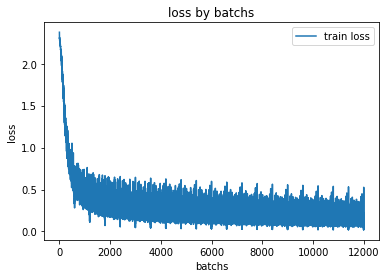

In [10]:
# グラフの描画
x = torch.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train loss')
plt.xlabel('batchs')
plt.ylabel('loss')
plt.title('loss by batchs')
plt.legend(loc='upper right')
plt.show()

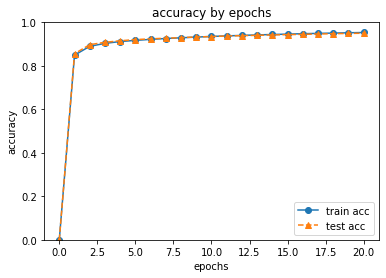

In [11]:
# グラフの描画
x = torch.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc', marker='o')
plt.plot(x, test_acc_list, label='test acc', linestyle='--', marker='^')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy by epochs')
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [24]:
x_test = None
t_test = None
test_predict = None

# テストの実行
model.eval()
for batch, (X, y) in enumerate(test_dataloader):
    with torch.no_grad():
        pred = model(X)
        x_test = torch.cat((x_test,X),0) if x_test is None else X
        t_test = torch.cat((t_test,y),0) if t_test is None else y
        test_predict = torch.cat((test_predict,pred),0) if test_predict is None else pred

print(t_test)
#print(test_predict.shape)
for index in range(3):
    print('index = ' + str(index))
    print(test_predict[index])
    print(t_test[index])

TypeError: expected Tensor as element 0 in argument 0, but got NoneType

In [17]:
# エラー結果のみの要素を抽出
index_error = torch.argmax(test_predict, axis=1) != t_test
error_list = torch.arange(len(test_predict))[index_error]
print(f'error rate = {len(error_list) / len(test_predict) * 100}[%]')


error rate = 2.0[%]


In [ ]:

# 画像を表示
figure = plt.figure(figsize=(16, 8))
rows, cols = 3, 6
for i in range(rows * cols):
    index = error_list[i]
    img, label_t, label_y = x_test[index], t_test[index].argmax(), test_predict[index].argmax()
    figure.add_subplot(rows, cols, i + 1)
    plt.title(f'{label_y} (t={label_t})')
    plt.axis('off')
    img = img.reshape(28, 28)  # 28x28 に変換
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()